In [ ]:
!pip install scipy==1.9.3 --force-reinstall

In [2]:
# import scipy
# def derivative(func, x0, dx=1e-6, n=1, order=3):
#     if n != 1 or order != 3:
#         raise NotImplementedError("Only n=1 and order=3 supported")
#     return (func(x0 + dx) - func(x0 - dx)) / (2 * dx)

# scipy.misc.derivative = derivative

import math
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from ADRpy import atmospheres as at
from importlib import reload
import helper_functions
helper_functions = reload(helper_functions)
from helper_functions import *
import specs
specs = reload(specs)
from specs import *
import subprocess
import os
from airfoils import Airfoil

In [3]:
foil = Airfoil.NACA4('2412')
x,y = foil.all_points

foil_vt = Airfoil.NACA4('0012')
x_vt,y_vt = foil_vt.all_points

In [4]:
def save_airfoil_as_dat(filename, name, x, y):
    """
    Save airfoil coordinates to a .dat file in Selig format.

    Parameters:
        filename (str): Path to save the file (e.g., 'NACA2412.dat')
        name (str): Airfoil name to be written as the first line
        x (array-like): x-coordinates
        y (array-like): y-coordinates
    """
    with open(filename, 'w') as f:
        f.write(f"   {name}\n")
        for xi, yi in zip(x, y):
            f.write(f"  {xi:8.5f}     {yi:8.5f}\n")

save_airfoil_as_dat("naca0012_coords.dat", "NACA0012", x_vt, y_vt)

In [5]:
def get_aerodynamic_coeffs_for_airfoil(correct_airfoil_name_with_space, Reynolds_number, from_dat=False):
    xfoil_path = os.path.join(os.getcwd(), r"..\XFOIL6.99\xfoil.exe")

    # Define the commands to be sent to XFOIL
    commands = f"""
    {correct_airfoil_name_with_space}
    OPER
    VISC {Reynolds_number}
    PACC
    {correct_airfoil_name_with_space}-{int(Reynolds_number)}.dat

    ASEQ -5 15 0.1

    QUIT
    """
    if from_dat:
        commands = f"""
    LOAD {correct_airfoil_name_with_space}-{int(Reynolds_number)}.dat
    PANE
    OPER
    VISC {Reynolds_number}
    PACC
    {correct_airfoil_name_with_space}-{int(Reynolds_number)}-polar.dat

    ASEQ -5 15 0.1

    QUIT
    """

    print(commands)
    # Write the commands to a temporary file
    with open('xfoil_input.txt', 'w') as f:
        f.write(commands)

    # Execute XFOIL with the input file
    with open('xfoil_input.txt', 'r') as input_file, open('xfoil_output.txt', 'w') as output_file:
        subprocess.run(xfoil_path, stdin=input_file, stdout=output_file)

def load_xfoil_polar(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    data_lines = []
    start_collecting = False

    for line in lines:
        line = line.strip()

        # Identify the line with column headers
        if line.startswith("alpha") and "CL" in line:
            start_collecting = True
            continue

        # Skip lines until data starts
        if start_collecting:
            # Stop if blank line or end of numeric data
            if not line or not any(char.isdigit() for char in line):
                continue

            # Try to parse the data
            try:
                parts = line.split()
                if len(parts) == 7:
                    alpha, cl, cd, cdp, cm, top_xtr, bot_xtr = map(float, parts)
                    data_lines.append([alpha, cl, cd, cdp, cm, top_xtr, bot_xtr])
            except ValueError:
                continue  # Skip malformed lines

    df = pd.DataFrame(data_lines, columns=["alpha", "CL", "CD", "CDp", "CM", "Top_Xtr", "Bot_Xtr"])
    return df

def get_coefficients_at_alpha(df, alpha):
    """
    Interpolate aerodynamic coefficients from XFOIL polar DataFrame.

    Parameters:
        df (pd.DataFrame): Must contain 'alpha', 'CL', 'CD', 'CDp', 'CM', 'Top_Xtr', 'Bot_Xtr'
        alpha (float): Angle of attack in degrees

    Returns:
        dict: Interpolated coefficients at the specified alpha
    """
    if df.empty:
        raise ValueError("Input DataFrame is empty")

    # Ensure the DataFrame is sorted by alpha
    df_sorted = df.sort_values("alpha")

    # Check alpha bounds
    if not (df_sorted["alpha"].min() <= alpha <= df_sorted["alpha"].max()):
        raise ValueError(f"Alpha {alpha} is out of bounds ({df_sorted['alpha'].min()} to {df_sorted['alpha'].max()})")

    # Interpolate each column
    coeffs = {}
    for col in ["CL", "CD", "CDp", "CM", "Top_Xtr", "Bot_Xtr"]:
        coeffs[col] = np.interp(alpha, df_sorted["alpha"], df_sorted[col])

    coeffs["alpha"] = alpha
    return coeffs

def get_cl_alpha_at(df, alpha, delta=0.5):
    """
    Approximates the local lift curve slope dCl/dα at a specified angle of attack.

    Parameters:
        df (pd.DataFrame): Polar data with columns 'alpha' and 'CL'
        alpha (float): Angle of attack in degrees at which to compute the slope
        delta (float): Small delta around alpha for finite difference (in degrees)

    Returns:
        float: Estimated dCl/dα (1/deg)
    """
    df = df.sort_values("alpha")

    alpha_min = -5
    alpha_max = 10

    if not (alpha_min <= alpha - delta and alpha + delta <= alpha_max):
        raise ValueError(f"Alpha ± delta must be within data bounds ({alpha_min} to {alpha_max})")

    # Interpolate CL at alpha ± delta
    cl_plus = np.interp(alpha + delta, df["alpha"], df["CL"])
    cl_minus = np.interp(alpha - delta, df["alpha"], df["CL"])

    cl_alpha = (cl_plus - cl_minus) / (2 * delta)
    return cl_alpha

def get_row_for_cl(df, target_cl):
    """
    Interpolate the polar data to find the row corresponding to a target CL.

    Parameters:
        df (pd.DataFrame): Must contain columns 'alpha' and 'CL'
        target_cl (float): Desired lift coefficient

    Returns:
        dict: Interpolated row with keys: alpha, CL, CD, CDp, CM, Top_Xtr, Bot_Xtr
    """
    df = df.sort_values("CL")

    if not (df["CL"].min() <= target_cl <= df["CL"].max()):
        raise ValueError(f"CL = {target_cl} is out of bounds ({df['CL'].min()} to {df['CL'].max()})")

    # Find bracketing rows
    lower_idx = df[df["CL"] <= target_cl]["CL"].idxmax()
    upper_idx = df[df["CL"] >= target_cl]["CL"].idxmin()

    row_low = df.loc[lower_idx]
    row_high = df.loc[upper_idx]

    if lower_idx == upper_idx:
        return row_low.to_dict()  # Exact match

    # Linear interpolation factor
    t = (target_cl - row_low["CL"]) / (row_high["CL"] - row_low["CL"])

    interpolated = {}
    for col in ["alpha", "CL", "CD", "CDp", "CM", "Top_Xtr", "Bot_Xtr"]:
        interpolated[col] = (1 - t) * row_low[col] + t * row_high[col]

    return interpolated


In [ ]:
def get_airfoil_params_with_flap_effect(correct_airfoil_name_with_space, Reynolds_numbers, deflection_angles, phases):
    xfoil_path = os.path.join(os.getcwd(), r"..\XFOIL6.99\xfoil.exe")

    for deflection in deflection_angles:
        for Reynolds_number in Reynolds_numbers:
            # Define the commands to be sent to XFOIL
            commands = f"""
            {correct_airfoil_name_with_space}
            PANE
            GDES
            HING
            0.7
            FLAP
            0.0 {deflection}
            EXEC
            PANE
            OPER
            VISC {Reynolds_number}
            PACC
            ht_deflections\{correct_airfoil_name_with_space}-{phases[Reynolds_numbers.index(Reynolds_number)]}({deflection} deg).dat

            ASEQ -5 15 0.1

            QUIT
            """.strip()

            
            # Write the commands to a temporary file
            with open('xfoil_input.txt', 'w') as f:
                f.write(commands)

            # Execute XFOIL with the input file
            with open('xfoil_input.txt', 'r') as input_file, open('xfoil_output.txt', 'w') as output_file:
                subprocess.run(xfoil_path, stdin=input_file, stdout=output_file)

                

In [38]:
creationflags = subprocess.CREATE_NO_WINDOW
startupinfo = subprocess.STARTUPINFO()
startupinfo.dwFlags |= subprocess.STARTF_USESHOWWINDOW
startupinfo.wShowWindow = 0  # SW_HIDE

In [41]:
def get_airfoil_params_with_flap_effect_naca(airfoil_name, Reynolds_numbers, deflection_angles, phases, output_dir="ht_deflections"):
    """
    Run XFOIL using built-in NACA airfoil with flap deflections at different Re.
    
    Args:
        airfoil_name: e.g., "2412"
        Reynolds_numbers: list of Re values
        deflection_angles: list of flap deflections in degrees
        phases: list of labels (e.g., flight phases) corresponding to Re
        output_dir: directory to save polar files
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Path to XFOIL executable
    xfoil_path = os.path.join(os.getcwd(), r"..\XFOIL6.99\xfoil.exe")
    
    # Check if XFOIL exists
    if not os.path.isfile(xfoil_path):
        raise FileNotFoundError(f"XFOIL executable not found at: {xfoil_path}")

    for deflection in deflection_angles:
        for Re, phase in zip(Reynolds_numbers, phases):
            print(f"Running: NACA {airfoil_name}, Deflection={deflection}°, Re={Re} ({phase})")

            # Output polar file
            output_polar = os.path.join(output_dir, f"NACA{airfoil_name}_def ({deflection} deg)_{phase}.plr")
            
            # Build XFOIL command input
            commands = f"""
            NACA {airfoil_name}
            PANE
            GDES
            FLAP
            0.7
            0.0
            {deflection}
            EXEC
            
            PANE                    ! Critical: repanel after modification
            OPER
            VISC {Re}
            ITER 100
            PACC
            {output_polar}
            
            ASEQ -5 15 0.5           ! Alpha sweep: -5 to +15 deg, 0.5 deg step
            QUIT
            """.strip()

            # Write commands to temp input file
            input_file = 'xfoil_temp_input.txt'
            with open(input_file, 'w') as f:
                f.write(commands)


            # Run XFOIL
            try:
                with open(input_file, 'r') as infile:
                    result = subprocess.run(
                        xfoil_path,
                        stdin=infile,
                        stdout=subprocess.PIPE,
                        stderr=subprocess.PIPE,
                        text=True,
                        timeout=60,  # seconds
                        creationflags = creationflags,
                        startupinfo=startupinfo
                    )
                
            except Exception as e:
                print(f"❌ Failed to run XFOIL: {e}")
                # pass

    # Cleanup
    if os.path.exists('xfoil_temp_input.txt'):
        os.remove('xfoil_temp_input.txt')

In [ ]:
Reynolds_numbers = [calculate_reynolds_number(80, 1, 0), calculate_reynolds_number(150, 1, 2500)]
deflection_angles = list(range(-15,16,1))  # degrees
phases = ["takeoff", "cruise"]  # one per Re

get_airfoil_params_with_flap_effect_naca(
    airfoil_name="2412",
    Reynolds_numbers=Reynolds_numbers,
    deflection_angles=deflection_angles,
    phases=phases
)

In [16]:
get_airfoil_params_with_flap_effect("NACA 2412", Reynolds_numbers=[
    calculate_reynolds_number(150, 1, 2500),
    calculate_reynolds_number(80, 1, 0)
], deflection_angles = list(range(-15,16,1)), phases=["cruise", "takeoff"])

In [ ]:
#(200, 1, 3000)
# (80, 1, 3000)
get_aerodynamic_coeffs_for_airfoil("NACA 2412",Reynolds_number=calculate_reynolds_number(80, 1, 0), from_dat=False)


    NACA 2412
    OPER
    VISC 1521321.0756433154
    PACC
    NACA 2412-1521321.dat

    ASEQ -5 15 0.1

    QUIT
    


In [69]:
airfoil_coeffs_vs_alpha = load_xfoil_polar(f'NACA 2412-{int(calculate_reynolds_number(200, 1, 3000))}.dat')
airfoil_coeffs_vs_alpha_to = load_xfoil_polar(f'NACA 2412-{int(calculate_reynolds_number(80, 1, 0))}.dat')
airfoil_coeffs_vs_alpha_vt = load_xfoil_polar(f'NACA 0012-{int(calculate_reynolds_number(200, 1, 3000))}.dat')



In [251]:
def initial_design_feasibility_pass(current_values, assumed_and_set):
    # Unpack Inputs
    mtow = current_values["mtow"]
    cl_cruise = current_values["cl_cruise"]
    cruise_speed_kmh = current_values["cruise_speed_kmh"]
    altitude_m = assumed_and_set.get("cruise_altitude_m", 0)
    rho = get_air_density(altitude_m)
    v_ms = kmh_to_ms(cruise_speed_kmh)

    # 1. Calculate Initial Wing Area
    current_values["wing_area_m2"] = (2 * mtow * g) / (rho * v_ms**2 * cl_cruise)

    # 2. Wing Loading
    current_values["wing_loading_pa"] = (mtow * g) / current_values["wing_area_m2"]

    # 3. Wing Geometry
    AR = current_values["aspect_ratio"]
    current_values["wing_span_m"] = (current_values["wing_area_m2"] * AR)**0.5
    current_values["chord_m"] = current_values["wing_area_m2"] / current_values["wing_span_m"]

    # 4. Fuselage Geometry
    fuselage_length = assumed_and_set["fuselage_length_mac_coeff"] * current_values["chord_m"]
    current_values["fuselage_body_length_m"] = fuselage_length
    current_values["wing_le_position_m"] = assumed_and_set["wing_le_position_fuselage_length_coeff"] * fuselage_length

    # 5. Tail Arm and Tail Areas
    tail_arm = assumed_and_set["horizontal_tail_arm_mac_coeff"] * current_values["chord_m"]
    current_values["tail_arm_m"] = tail_arm
    Vh = assumed_and_set["horizontal_tail_volume_coefficient"]
    Vv = assumed_and_set["vertical_tail_volume_coefficient"]
    current_values["horizontal_tail_area_m2"] = Vh * current_values["wing_area_m2"] * current_values["chord_m"] / tail_arm
    current_values["vertical_tail_area_m2"] = Vv * current_values["wing_area_m2"] * current_values["wing_span_m"] / tail_arm

    return current_values


def stability_analysis(
    chord_m,
    cg_m,
    tail_volume_coeff,
    wing_le_position_m
):
    Vh = tail_volume_coeff

    neutral_point_m = wing_le_position_m + 0.25 * chord_m + Vh * chord_m
    static_margin = (neutral_point_m - cg_m) / chord_m


    return {
        "neutral_point_m": neutral_point_m,
        "static_margin": static_margin,
    }

def cruise_trim_analysis(
    neutral_point_m,
    cg_from_nose,
    cl_cruise,
    tail_arm_m,
    eta_h,
    delta_cl_from_thrust,
):
    

    cl_tail = ((cg_from_nose - neutral_point_m) * cl_cruise / tail_arm_m) + delta_cl_from_thrust
    
    alpha_tail = get_row_for_cl(airfoil_coeffs_vs_alpha, cl_tail)["alpha"]
    cl_alpha_tail =  get_cl_alpha_at(airfoil_coeffs_vs_alpha, alpha_tail, delta=0.1) # from airfoil data at Re=500k

    # print(cl_tail,alpha_tail, cl_alpha_tail)
    delta_e_deg = cl_tail / (cl_alpha_tail * eta_h)
    
    
    return {
        "cl_tail_required": cl_tail,
        "delta_elevator_deg": delta_e_deg,
    }

def get_delt_cl_from_thrust(current_values, hard_constraints, phase):
    

    rho = get_air_density(hard_constraints["cruise_altitude_m"])
    v_ms = kmh_to_ms(current_values[f"{phase}_speed_kmh"])
    q = 0.5 * rho * v_ms**2

    # 4. Tail area (needed to convert moment to tail lift)
    S_h = current_values["horizontal_tail_area_m2"]
    thrust = current_values[f"{phase}_power_kw"] * 1000 / v_ms  # in N
    moment_thrust = - thrust * current_values[f"{phase}_cg_from_floor_m"]  # in Nm
    delta_cl_tail_thrust = moment_thrust / (q * S_h * current_values["tail_arm_m"])

    return delta_cl_tail_thrust

def tail_geometry(area_m2, aspect_ratio):
    span_m = (area_m2 * aspect_ratio) ** 0.5
    chord_m = area_m2 / span_m
    return span_m, chord_m
    




In [252]:
def get_fuselage_mass(fuselage_length, fuselage_width, fuselage_height, assumed_and_set):
    skin_thickness = sandwich_specs["fuselage"]["total_thickness_m"] - sandwich_specs["fuselage"]["core_thickness_m"]
    skin_cross_sectional_cirfumferance = (fuselage_width + fuselage_height)
    skin_cross_sectional_area = skin_cross_sectional_cirfumferance * skin_thickness
    total_skin_volume = fuselage_length * skin_cross_sectional_area
    skin_density = assumed_and_set["gfrp_density_kgm3"]
    total_skin_mass = total_skin_volume * skin_density
    
    core_thickness = sandwich_specs["fuselage"]["core_thickness_m"]
    core_cross_sectional_cirfumferance = 2 * (fuselage_width + fuselage_height)
    core_cross_sectional_area = core_cross_sectional_cirfumferance * core_thickness
    total_core_volume = fuselage_length * core_cross_sectional_area
    core_density = assumed_and_set["core_density_kgm3"]
    total_core_mass = total_core_volume * core_density

    total_fuselage_mass = total_skin_mass + total_core_mass

    return total_fuselage_mass

def airfoil_perimeter_length(x, y, chord):
    """
    Compute total surface length of an airfoil given x and y coordinates.

    Parameters:
        x (array-like): x coordinates of the airfoil surface
        y (array-like): y coordinates of the airfoil surface

    Returns:
        float: total length along the airfoil perimeter
    """
    x = np.array(x)
    y = np.array(y)

    dx = np.diff(x)
    dy = np.diff(y)
    segment_lengths = np.sqrt(dx**2 + dy**2)
    total_length = np.sum(segment_lengths) * chord
    
    return total_length

def get_wing_or_tail_mass(span, cross_section_perimeter_length, tail_or_wing, assumed_and_set):

    
    skin_thickness = sandwich_specs[tail_or_wing]["total_thickness_m"] - sandwich_specs[tail_or_wing]["core_thickness_m"]
    skin_cross_sectional_cirfumferance = cross_section_perimeter_length
    skin_cross_sectional_area = skin_cross_sectional_cirfumferance * skin_thickness
    total_skin_volume = span * skin_cross_sectional_area
    skin_density = assumed_and_set["gfrp_density_kgm3"]
    total_skin_mass = total_skin_volume * skin_density
    
    core_thickness = sandwich_specs[tail_or_wing]["core_thickness_m"]
    core_cross_sectional_cirfumferance = cross_section_perimeter_length
    core_cross_sectional_area = core_cross_sectional_cirfumferance * core_thickness
    total_core_volume = span * core_cross_sectional_area
    core_density = assumed_and_set["core_density_kgm3"]
    total_core_mass = total_core_volume * core_density

    total_wing_mass = total_skin_mass + total_core_mass

    return total_wing_mass

In [253]:
def size_fuselage_diameter_as_per_payload(internal_payload_count, internal_payload_diameter):
    n = internal_payload_count     # number of cylinders
    d = internal_payload_diameter  # cylinder diameter (m)
    s = 0.02               # spacing between cylinders (m)
    t = 0.015              # carousel mechanism radial thickness (m)

    # 1. Effective diameter
    d_eff = d + s

    # 2. Center-to-center radius
    r_center = d_eff / (2 * math.sin(math.pi / n))

    # 3. Outer radius including half the effective diameter
    R_cylinders = r_center + d_eff/2

    # 4. Add carousel thickness
    R_total = R_cylinders + t

    # 5. Required fuselage diameter
    D_required = 2 * R_total

    return D_required + 0.03

def initial_size_fuselage(hard_constraints, assumed_and_set, iterable_constraints, fuselage_tank_in_wing_root=True):

    nose_for_ballast_and_aerodynamics_length = 0.5
    ## fuel

    # fuel_volume = (iterable_constraints["fuel_kg"] / assumed_and_set["fuel_density_kgL"]) / 1000

    # fuselage_cross_section_area = 0.6*0.45 # sized around engine cross section
    # fuselage_length_for_fuel = 0.03 + (fuel_volume / fuselage_cross_section_area)
    fuselage_length_for_fuel = assumed_and_set["fuselage_fuel_tank_length"]
    
    # ## payload

    internal_payload_length = hard_constraints["internal_payload_length"]

    
    ## avionics (computers, sensors, camera)

    fuselage_length_for_avionics = 0.7 # m 

    ## wing root requirements

    fuselage_length_for_wing_root = 1.2 * iterable_constraints["chord_m"] # this would include the center wing box

    ## powerplant

    fuselage_length_for_engine = 1 # engine length is 0.7 , added 0.3 for filters and controls

    if fuselage_tank_in_wing_root:
        total_fuselage_length = nose_for_ballast_and_aerodynamics_length + internal_payload_length + fuselage_length_for_avionics + fuselage_length_for_wing_root + fuselage_length_for_engine
    else:
        total_fuselage_length = nose_for_ballast_and_aerodynamics_length + fuselage_length_for_fuel + internal_payload_length + fuselage_length_for_avionics + fuselage_length_for_wing_root + fuselage_length_for_engine

    return total_fuselage_length

In [254]:
def refine_design_from_iterable_constraints(hard_constraints, assumed_and_set, weights_dict_kg_no_fuel, iterable_constraints, target_error=0.02, max_iterations=10):
    # populate constants and constraints

    # try:
        current_values = iterable_constraints.copy()

        prev_values = current_values.copy()

        for i in range(max_iterations):

            ## cruise iterations

            # print(f"[Iter {i+1}] " + " | ".join([f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}" for k, v in current_values.items()]))
            
            h_tail_te_position = current_values["tail_arm_m"] + current_values["cruiseout_cg_from_nose_m"] + 0.75*current_values["h_tail_chord_m"]
            # print(current_values["fuselage_body_length_m"], h_tail_te_position)
            
            cruiseout_v_ms = kmh_to_ms(current_values["cruiseout_speed_kmh"])
            rho = get_air_density(hard_constraints["cruise_altitude_m"])
            current_values["wing_area_m2"] = calc_required_wing_area(current_values["mtow"], current_values["cruiseout_cl"], rho, cruiseout_v_ms)
            
            ## cruise out calculations
            # Aerodynamics 
            cruiseout_mtow = current_values["mtow"]
            current_values["cruiseout_cl"] = calc_cl_cruise(cruiseout_mtow, current_values["cruiseout_speed_kmh"], current_values["wing_area_m2"], hard_constraints["cruise_altitude_m"])
            current_values["cruiseout_angle_of_attack_deg"] = get_row_for_cl(airfoil_coeffs_vs_alpha, current_values["cruiseout_cl"])["alpha"]
            current_values["cruiseout_cd"] = calc_cd_total(airfoil_coeffs_vs_alpha["CD"].min(), current_values["cruiseout_cl"], assumed_and_set["aspect_ratio"])
            current_values["cruiseout_lift_to_drag"] = current_values["cruiseout_cl"] / current_values["cruiseout_cd"]
            cruiseout_drag_n = 0.5 * rho * cruiseout_v_ms**2 * current_values["wing_area_m2"] * current_values["cruiseout_cd"]
            cruiseout_power_kw = cruiseout_drag_n * cruiseout_v_ms / propeller_specs["efficiency"]["cruise"] / engine_specs["gear_box_efficiency"] / 1000  # kW
            current_values["cruiseout_power_kw"] = cruiseout_power_kw

            # Engine interpolation
            cruiseout_sfc_data = estimate_cruise_sfc_from_dicts(engine_power_to_rpm, engine_sfc_to_rpm, cruiseout_power_kw)
            current_values["cruiseout_sfc"] = cruiseout_sfc_data["sfc_cruise"]
            current_values["cruiseout_rpm"] = cruiseout_sfc_data["rpm_cruise"]
            current_values["cruiseout_time"] = hard_constraints["target_station_distance_km"] / current_values["cruiseout_speed_kmh"] # in hours

            cruiseout_fuel_requirement = cruiseout_power_kw * current_values["cruiseout_time"] * current_values["cruiseout_sfc"] 

            ## loiter calculations
            # Aerodynamics 
            loiter_v_ms = kmh_to_ms(current_values["loiter_speed_kmh"])
            loiter_mtow = current_values["mtow"] - cruiseout_fuel_requirement
            current_values["loiter_cl"] = calc_cl_cruise(loiter_mtow, current_values["loiter_speed_kmh"], current_values["wing_area_m2"], hard_constraints["cruise_altitude_m"])
            current_values["loiter_angle_of_attack_deg"] = get_row_for_cl(airfoil_coeffs_vs_alpha, current_values["loiter_cl"])["alpha"]
            current_values["loiter_cd"] = calc_cd_total(airfoil_coeffs_vs_alpha["CD"].min(), current_values["loiter_cl"], assumed_and_set["aspect_ratio"])
            current_values["loiter_lift_to_drag"] = current_values["loiter_cl"] / current_values["loiter_cd"]
            loiter_drag_n = 0.5 * rho * loiter_v_ms**2 * current_values["wing_area_m2"] * current_values["loiter_cd"]
            loiter_power_kw = loiter_drag_n * loiter_v_ms / propeller_specs["efficiency"]["cruise"] / engine_specs["gear_box_efficiency"] / 1000  # kW
            current_values["loiter_power_kw"] = loiter_power_kw

            # Engine interpolation
            loiter_sfc_data = estimate_cruise_sfc_from_dicts(engine_power_to_rpm, engine_sfc_to_rpm, loiter_power_kw)
            current_values["loiter_sfc"] = loiter_sfc_data["sfc_cruise"]
            current_values["loiter_rpm"] = loiter_sfc_data["rpm_cruise"]

            loiter_fuel_requirement = loiter_power_kw * hard_constraints["loiter_time"] * 1.1 * current_values["loiter_sfc"] 

            estimate_loiter_fuel = loiter_power_kw * hard_constraints["loiter_time"] * 1.1 * current_values["cruiseout_sfc"] ## 1.2 is a multiplier to estimate the increased SFC at the lower RPM during loiter
            

            ## cruise back calculations
            # Aerodynamics 
            cruiseback_v_ms = kmh_to_ms(current_values["cruiseback_speed_kmh"])
            cruiseback_mtow = current_values["mtow"] - cruiseout_fuel_requirement - loiter_fuel_requirement - hard_constraints["internal_payload_mass"] - hard_constraints["wing_payload_mass"]
            current_values["cruiseback_cl"] = calc_cl_cruise(cruiseback_mtow, current_values["cruiseback_speed_kmh"], current_values["wing_area_m2"], hard_constraints["cruise_altitude_m"])
            current_values["cruiseback_angle_of_attack_deg"] = get_row_for_cl(airfoil_coeffs_vs_alpha, current_values["cruiseback_cl"])["alpha"]
            current_values["cruiseback_cd"] = calc_cd_total(airfoil_coeffs_vs_alpha["CD"].min(), current_values["cruiseback_cl"], assumed_and_set["aspect_ratio"])
            current_values["cruiseback_lift_to_drag"] = current_values["cruiseback_cl"] / current_values["cruiseback_cd"]
            cruiseback_drag_n = 0.5 * rho * cruiseback_v_ms**2 * current_values["wing_area_m2"] * current_values["cruiseback_cd"]
            cruiseback_power_kw = cruiseback_drag_n * cruiseback_v_ms / propeller_specs["efficiency"]["cruise"] / engine_specs["gear_box_efficiency"] / 1000  # kW
            current_values["cruiseback_power_kw"] = cruiseback_power_kw

            # Engine interpolation
            cruiseback_sfc_data = estimate_cruise_sfc_from_dicts(engine_power_to_rpm, engine_sfc_to_rpm, cruiseback_power_kw)
            current_values["cruiseback_sfc"] = cruiseback_sfc_data["sfc_cruise"]
            current_values["cruiseback_rpm"] = cruiseback_sfc_data["rpm_cruise"]
            current_values["cruiseback_time"] = hard_constraints["target_station_distance_km"] / current_values["cruiseback_speed_kmh"] # in hours

            cruiseback_fuel_requirement = cruiseback_power_kw * current_values["cruiseback_time"] * current_values["cruiseback_sfc"] 


            current_values["fuel_kg"] = cruiseout_fuel_requirement + estimate_loiter_fuel + cruiseback_fuel_requirement

            current_values["mtow"]  = sum(weights_dict_kg_no_fuel.values()) + current_values["fuel_kg"]

            # Wing geometry - stays fixed for following flight stages
            current_values["wing_area_m2"] = calc_required_wing_area(current_values["mtow"], current_values["cruiseout_cl"], rho, cruiseout_v_ms)
            current_values["wing_span_m"] = np.sqrt(current_values["wing_area_m2"] * assumed_and_set["aspect_ratio"])
            current_values["chord_m"] = current_values["wing_area_m2"] / current_values["wing_span_m"]
            current_values["wing_loading_pa"] = current_values["mtow"] * g / current_values["wing_area_m2"] 

            current_values["tail_arm_m"] = assumed_and_set["horizontal_tail_arm_mac_coeff"] * current_values["chord_m"]

            # --- Horizontal Tail Area (S_h) ---
            current_values["horizontal_tail_area_m2"] = assumed_and_set["horizontal_tail_volume_coefficient"] *  (current_values["wing_area_m2"] * current_values["chord_m"]) / current_values["tail_arm_m"]
            

            current_values["h_tail_span_m"], current_values["h_tail_chord_m"] = tail_geometry(current_values["horizontal_tail_area_m2"], assumed_and_set["AR_horizontal"])
            
            # --- Vertical Tail Area (S_v) ---
            current_values["vertical_tail_area_m2"] = assumed_and_set["vertical_tail_volume_coefficient"] *(current_values["wing_area_m2"] * current_values["wing_span_m"]) /current_values["tail_arm_m"]
            

            current_values["v_tail_span_m"], current_values["v_tail_chord_m"] = tail_geometry(current_values["vertical_tail_area_m2"], assumed_and_set["AR_vertical"])
            # current_values["v_tail_span_m"], current_values["v_tail_chord_m"] = tail_geometry(current_values["vertical_tail_area_m2"], 2.0)  # Assuming AR of 2.0 for vertical tail


            # --- Fuselage Geometry ---
            

            current_values["fuselage_body_length_m"] = initial_size_fuselage(hard_constraints, assumed_and_set, current_values, False)
            # current_values["fuselage_body_length_m"] = h_tail_te_position

            # current_values["fuselage_tail_arm_extension_m"] = max(0, h_tail_te_position - current_values["fuselage_body_length_m"])

            # if current_values["fuselage_tail_arm_extension_m"] == 0:
            wing_le_position_m = assumed_and_set["wing_le_position_fuselage_length_coeff"] * current_values["fuselage_body_length_m"]
            current_values["wing_le_position_m"] = wing_le_position_m
            

            # --- range, endurance, and fuel requirements ---

            cruise_fuel = cruiseout_fuel_requirement
            loiter_fuel = loiter_fuel_requirement

            cb = current_values["loiter_sfc"]
            rho = get_air_density(hard_constraints["cruise_altitude_m"])
            w_0 = (current_values["mtow"] - cruise_fuel ) * g
            w_f = (current_values["mtow"] - cruise_fuel - loiter_fuel) * g

            Breguet_endurance = current_values["loiter_lift_to_drag"] * (1/cb) * np.log(w_0/w_f)

            current_values["calculated_loiter_time"] = Breguet_endurance  # in hours

            ## fuel tank calculations
            current_values["required_fuel_volume_m3"] = current_values["fuel_kg"] / assumed_and_set["fuel_density_kgL"] / 1000
            current_values["max_theoretical_range"] = current_values["cruiseout_speed_kmh"]  * (current_values["fuel_kg"]/2) / (current_values["cruiseout_power_kw"] * current_values["cruiseout_sfc"])

            fuselage_cross_section_area = (current_values["fuselage_body_width_m"] - 2*sandwich_specs["fuselage"]["total_thickness_m"] - 0.02) *( current_values["fuselage_body_height_m"] - 2*sandwich_specs["fuselage"]["total_thickness_m"] - 0.02)
            fuselage_fuel_tank = assumed_and_set["fuselage_fuel_tank_length"] * fuselage_cross_section_area #cross_section_area_fuselage_fuel_tank(iterable_constraints["fuselage_diameter_m"], 0.8)
            wing_fuel_tank = wing_fuel_tank_volume("naca2412_coords.dat", current_values, 0.25, 0.65)
            current_values["space_available_for_fuel_m3"] = fuselage_fuel_tank + wing_fuel_tank
            
            if current_values["required_fuel_volume_m3"] < fuselage_fuel_tank:
                fuselage_fuel = current_values["fuel_kg"]
            else:
                fuselage_fuel = fuselage_fuel_tank * 1000 * assumed_and_set["fuel_density_kgL"]  

            wing_fuel = current_values["fuel_kg"] - fuselage_fuel

            # airframe mass estimation

            fuselage_mass = get_fuselage_mass(current_values["fuselage_body_length_m"], current_values["fuselage_body_width_m"], 
                                            current_values["fuselage_body_height_m"], assumed_and_set) * assumed_and_set["fuselage_internal_supports_mass_multiplier"]
            weights_dict_kg_no_fuel["fuselage"] = fuselage_mass

            wing_cross_section_perimeter_length = airfoil_perimeter_length(x, y, current_values["chord_m"])
            wing_mass = get_wing_or_tail_mass(current_values["wing_span_m"], wing_cross_section_perimeter_length,"wing", assumed_and_set) * assumed_and_set["wing_internal_supports_mass_multiplier"]
            weights_dict_kg_no_fuel["wing"] = wing_mass
            
            horizontal_tail_perimeter = airfoil_perimeter_length(x, y, current_values["h_tail_chord_m"])
            horizontal_tail_mass = get_wing_or_tail_mass(current_values["h_tail_span_m"], horizontal_tail_perimeter,"tail", assumed_and_set) * assumed_and_set["tail_internal_supports_mass_multiplier"]

            vertical_tail_perimeter = airfoil_perimeter_length(x_vt, y_vt, current_values["v_tail_chord_m"])
            vertical_tail_mass = get_wing_or_tail_mass(current_values["v_tail_span_m"], vertical_tail_perimeter,"tail", assumed_and_set) * assumed_and_set["tail_internal_supports_mass_multiplier"]
            
            weights_dict_kg_no_fuel["horizontal_tail"] = horizontal_tail_mass
            weights_dict_kg_no_fuel["vertical_tail"] = vertical_tail_mass
            weights_dict_kg_no_fuel["tails"] = horizontal_tail_mass + vertical_tail_mass
            
            #cg position estimation
            cruiseout_weights_for_cg = weights_dict_kg_no_fuel.copy()
            cruiseout_weights_for_cg["fuselage_fuel"] = fuselage_fuel
            cruiseout_weights_for_cg["wing_fuel"] = wing_fuel


            #post payload drop


            # component_positions_m = estimate_component_positions(
            #     fuselage_length=current_values["fuselage_body_length_m"],
            #     wing_le_position=wing_le_position_m,
            #     chord=current_values["chord_m"],
            #     tail_arm=current_values["tail_arm_m"],
            #     internal_payload_length=hard_constraints["internal_payload_length"],
            #     fuselage_fuel_tank_length=assumed_and_set["fuselage_fuel_tank_length"],
            #     cg_estimate=current_values["cruiseout_cg_from_nose_m"],
            # )

            component_positions_m, component_positions_m_z = estimate_component_positions(current_values, hard_constraints, assumed_and_set, weights_dict_kg_no_fuel)
            ### cruise out stability and trim
            current_values["cruiseout_cg_from_nose_m"] = calculate_cg(cruiseout_weights_for_cg, component_positions_m)
            current_values["cruiseout_cg_from_floor_m"] = calculate_cg(cruiseout_weights_for_cg, component_positions_m_z)

            cruise_out_stability_dict = stability_analysis(current_values["chord_m"], current_values["cruiseout_cg_from_nose_m"], 
                                                        assumed_and_set["horizontal_tail_volume_coefficient"], current_values["wing_le_position_m"])
            
            current_values["neutral_point_m"] = cruise_out_stability_dict["neutral_point_m"]
            current_values["cruiseout_static_margin"] = cruise_out_stability_dict["static_margin"]

            # print(f"Static Margin: {current_values['static_margin']:.4f} | Static Margin Post Drop: {post_drop_vals['static_margin']:.4f}")
            eta_h = calculate_eta_h(current_values, phase="cruise")
            
            
            cruiseout_delt_cl_from_thrust = get_delt_cl_from_thrust(current_values, hard_constraints, "cruiseout")

            cruiseout_trim_dict = cruise_trim_analysis(current_values["neutral_point_m"], current_values["cruiseout_cg_from_nose_m"], 
                                                current_values["cruiseout_cl"], current_values["tail_arm_m"], eta_h, cruiseout_delt_cl_from_thrust)
            
            current_values["cruiseout_cl_tail_required"] = cruiseout_trim_dict["cl_tail_required"]
            current_values["cruiseout_delta_elevator_deg"] = cruiseout_trim_dict["delta_elevator_deg"]

            current_values.update(calculate_Cn_beta_phase(current_values, airfoil_coeffs_vs_alpha_vt, "cruiseout"))
            current_values.update(calculate_Cl_beta_phase(current_values, "cruiseout"))
            ### loiter stability and trim

            loiter_weights_for_cg = weights_dict_kg_no_fuel.copy()
            loiter_weights_for_cg["fuselage_fuel"] = min(fuselage_fuel - (wing_fuel - cruiseout_fuel_requirement), fuselage_fuel)
            loiter_weights_for_cg["wing_fuel"] = max(wing_fuel - cruiseout_fuel_requirement, 0)

            
            current_values["loiter_cg_from_nose_m"] = calculate_cg(loiter_weights_for_cg, component_positions_m)
            current_values["loiter_cg_from_floor_m"] = calculate_cg(loiter_weights_for_cg, component_positions_m_z)
            
            
            loiter_stability_dict = stability_analysis(current_values["chord_m"], current_values["loiter_cg_from_nose_m"], 
                                                        assumed_and_set["horizontal_tail_volume_coefficient"], current_values["wing_le_position_m"])
            
            
            current_values["loiter_static_margin"] = loiter_stability_dict["static_margin"]

            eta_h = calculate_eta_h(current_values, phase="loiter")
            
            loiter_delt_cl_from_thrust = get_delt_cl_from_thrust(current_values, hard_constraints, "loiter")

            loiter_trim_dict = cruise_trim_analysis(current_values["neutral_point_m"], current_values["loiter_cg_from_nose_m"], 
                                                current_values["loiter_cl"], current_values["tail_arm_m"], eta_h, loiter_delt_cl_from_thrust)
            
            current_values["loiter_cl_tail_required"] = loiter_trim_dict["cl_tail_required"]
            current_values["loiter_delta_elevator_deg"] = loiter_trim_dict["delta_elevator_deg"]

            current_values.update(calculate_Cn_beta_phase(current_values, airfoil_coeffs_vs_alpha_vt, "loiter"))
            current_values.update(calculate_Cl_beta_phase(current_values, "loiter"))
            ### cruiseback stability and trim

            cruiseback_weights_for_cg = weights_dict_kg_no_fuel.copy()
            cruiseback_weights_for_cg["fuselage_fuel"] = min(fuselage_fuel - (wing_fuel - cruiseout_fuel_requirement), fuselage_fuel)
            cruiseback_weights_for_cg["wing_fuel"] = max(wing_fuel - cruiseout_fuel_requirement, 0)
            cruiseback_weights_for_cg["internal_payload"] = 0
            cruiseback_weights_for_cg["wing_payload"] = 0
            
            current_values["cruiseback_cg_from_nose_m"] = calculate_cg(cruiseback_weights_for_cg, component_positions_m)
            current_values["cruiseback_cg_from_floor_m"] = calculate_cg(cruiseback_weights_for_cg, component_positions_m_z)

            cruiseback_stability_dict = stability_analysis(current_values["chord_m"], current_values["cruiseback_cg_from_nose_m"], 
                                                        assumed_and_set["horizontal_tail_volume_coefficient"], current_values["wing_le_position_m"])
            
            current_values["cruiseback_static_margin"] = cruiseback_stability_dict["static_margin"]

            # print(f"Static Margin: {current_values['static_margin']:.4f} | Static Margin Post Drop: {post_drop_vals['static_margin']:.4f}")
            eta_h = calculate_eta_h(current_values, phase="cruiseback")
            
            cruiseback_delt_cl_from_thrust = get_delt_cl_from_thrust(current_values, hard_constraints, "cruiseback")

            cruiseback_trim_dict = cruise_trim_analysis(current_values["neutral_point_m"], current_values["cruiseback_cg_from_nose_m"], 
                                                current_values["cruiseback_cl"], current_values["tail_arm_m"], eta_h, cruiseback_delt_cl_from_thrust)
            
            current_values["cruiseback_cl_tail_required"] = cruiseback_trim_dict["cl_tail_required"]
            current_values["cruiseback_delta_elevator_deg"] = cruiseback_trim_dict["delta_elevator_deg"]
            
            current_values.update(calculate_Cn_beta_phase(current_values, airfoil_coeffs_vs_alpha_vt, "cruiseback"))
            current_values.update(calculate_Cl_beta_phase(current_values, "cruiseback"))

            relative_errors = {
                k: abs(current_values[k] - prev_values[k]) / max(abs(current_values[k]), 1e-6)
                for k in current_values
            }

            
            for iter_key in prev_values:
                prev_values[iter_key] = current_values[iter_key]  # ← updates global dict

            if all(err < target_error for err in relative_errors.values()):

                for iter_key in iterable_constraints:
                    iterable_constraints[iter_key] = current_values[iter_key]  # ← updates global dict
                    
                if current_values["required_fuel_volume_m3"] > current_values["space_available_for_fuel_m3"]:
                    print(f"❌ Design failed: Required fuel volume {current_values['required_fuel_volume_m3']:.5f} m³ exceeds available space {current_values['space_available_for_fuel_m3']:.5f} m³.")
                    return current_values
                
                
                print(f"Converged in {i+1} iterations.")
                return current_values



        
        return current_values
    # except Exception as e:
    #     print("Design iteration did not converge.")
    #     return current_values

In [255]:

assumed_and_set = {
    # Mission requirements
    "rolling_resistance_coefficient": 0.04, # dimensionless   
    "target_drop_altitude_m": 2500,
    "sea_level_air_density": get_air_density(0),
    "horizontal_tail_volume_coefficient": 0.65, # dimensionless
    "vertical_tail_volume_coefficient": 0.03, # Computed Vv
    "horizontal_tail_arm_mac_coeff": 3.5, # dimensionless
    # "fuselage_length_mac_coeff": 5, # dimensionless
    "wing_le_position_fuselage_length_coeff": 0.55, # dimensionless
    # Configuration
    "fuel_density_kgL": 0.74,
    "gfrp_thickness_m": 0.0015, # meters
    "gfrp_density_kgm3": 2150, # kg/m^3
    "core_density_kgm3": 60,
    "fuselage_fuel_tank_length": 0.55, #meters
    "fuselage_internal_supports_mass_multiplier": 1.3,
    "wing_internal_supports_mass_multiplier": 1.3,
    "tail_internal_supports_mass_multiplier": 1.1,
    "aspect_ratio": 14  , # starting assumption
    "AR_horizontal": 4.0,                # aspect ratio of horizontal tail
    "AR_vertical": 2.0,                  # aspect ratio of vertical tail
    # "cl_alpha" : 8.44, # cl / angle of attack slope in (rad). taken from airfoil data
    "loiter_drag_multiplier": 1.05, ## assumes 5% extra drag due to turns, lower speed, and loss of energy
    "dihedral_deg": 4.0,                        # Wing dihedral angle (degrees)
    "wing_sweep_deg": 0.0,                      # Wing sweep at 25% chord (degrees)
    "high_wing_offset_m": 0.0,                  # Vertical distance from fuselage centerline to wing root (m)
    "elevator_chord_fraction": 0.35,            # Fraction of HT chord used for elevator
    "elevator_effectiveness_tau": 0.45,           # Rudder hinge efficiency (0.3–0.6 typical)  
    "rudder_chord_fraction": 0.35,              # Fraction of VT chord used for rudder
    "rudder_effectiveness_tau": 0.45,           # Rudder hinge efficiency (0.3–0.6 typical)    
    "wing_airfoil_thickness_ratio": 0.12, # Wing airfoil thickness ratio (12% for NACA 2412) same used for horizontal tail
    "vertical_tail_airfoil_thickness_ratio": 0.12, # Wing airfoil thickness ratio (12% for NACA 0012)
}

hard_constraints = {
    "wing_payload_mass" : 100, # kg
    "internal_payload_mass": 100, #kg
    "internal_payload_length": 1.3, # meter
    "target_station_distance_km": 300,
    "loiter_time": 1, # hours
    "takeoff_distance_max_m": 50, # dirt road
    "climb_time_min": 13, # minutes
    "cruise_altitude_m": 3000,  
}

weights_dict_kg_no_fuel = {
    "fuselage": 40,
    "wing": 230,
    "tails": 10,
    "internal_payload": hard_constraints["internal_payload_mass"],
    "wing_payload": hard_constraints["wing_payload_mass"],
    "engine": engine_specs["dry_weight_kg"],
    "propeller": propeller_specs["weight_kg"],
    "avionics": 40,
    "landing_gear": 20,
    "misc": 10,
}

iterable_constraints = {

    ## structural design variables
    #################################
    "wing_area_m2": 16, # starting assumption
    "wing_loading_pa": 500,
    "wing_span_m": 16, # meters
    "chord_m": 1,  # meters
    "neutral_point_m": 2.5, # meters
    "wing_le_position_m": 1.2824, # meters — same as before
    "rudder_area_m2": 0.0,                      # Area of rudder
    "elevator_area_m2": 0.0,                     # Area of elevator
    ## fuselage square section "body"
    "fuselage_body_length_m": 4.9,     # meters — same as before
    "fuselage_body_width_m": 0.62,     # meters — same as before
    "fuselage_body_height_m": 0.45,     # meters — same as before
    "fuselage_tail_arm_extension_m": 0, # meter
    ## fuselage nose section



    "space_available_for_fuel_m3": 0.05, # available space for fuel (m^3)

    "tail_arm_m": 2.3659,  # meters
    "tail_boom_pylon_height_m": 0.25, # meters
    
    "horizontal_tail_area_m2": 0.4351,    # square meters
    "h_tail_chord_m": 0.2579,               # meters
    "h_tail_span_m": 1.0,                  # meters

    "vertical_tail_area_m2": 0.1741,      # square meters
    "v_tail_chord_m": 0.1741,              # meters
    "v_tail_span_m": 1.0,                  # meters

    ## performance design variables
    ###################################
    "required_fuel_volume_m3": 0.02, # required fuel volume (m^3)
    "max_theoretical_range": 1.25*hard_constraints["target_station_distance_km"], # maximum theoretical range (km)
    "stall_speed_kmh": 55, # stall speed (km/h)
    "fuel_kg": 30, # kg starting assumption
    "mtow": sum(weights_dict_kg_no_fuel.values()) + 30, # starting assumption


    ## cruise out variables
    ##############################
    "cruiseout_speed_kmh": 150, #km/h
    "cruiseout_wing_loading_pa": 180, # starting assumption
    "cruiseout_cg_from_nose_m": 3.17574253884845,                # meters
    "cruiseout_cg_from_floor_m": 0.3,                # meters
    "cruiseout_cl": 0.8, # lift coefficient at cruise
    "cruiseout_cd" : 0.05, # drag coefficient at cruise
    "cruiseout_lift_to_drag": 16, # lift-to-drag ratio at cruise
    "cruiseout_sfc": 0.5, # specific fuel consumption at cruise (kg/kWh)
    "cruiseout_rpm": 5000, # engine RPM at cruise
    "cruiseout_power_kw": 8, # power required at cruise (kW)
    "cruiseout_static_margin": 0.1, # static margin (dimensionless)
    "cruiseout_delta_elevator_deg": 5, # elevator deflection angle (degrees)
    "cruiseout_cl_tail_required": -0.04, # required lift coefficient for tail
    "cruiseout_angle_of_attack_deg": 5, 
    "cruiseout_Cn_beta": 0.0,           # Yaw stability derivative (1/rad)
    "cruiseout_Cl_beta": 0.0,           # Roll due to sideslip (1/rad)
    "cruiseout_Cn_r": 0.0,              # Yaw from rudder deflection (1/rad)
    "cruiseout_Cl_r": 0.0,              # Roll from rudder (adverse roll, 1/rad)
    "cruiseout_Re_vt": 0.0,             # Reynolds number for vertical tail
    "cruiseout_time": 3, # cruise time (hours)

    ## loiter variables
    ###############################
    "loiter_speed_kmh": 150, #km/h
    "loiter_wing_loading_pa": 180, # starting assumption
    "loiter_cg_from_nose_m": 3.17574253884845,                # meters
    "loiter_cg_from_floor_m": 0.25,                # meters
    "loiter_cl": 0.8, # lift coefficient at loiter
    "loiter_cd" : 0.05, # drag coefficient at loiter
    "loiter_lift_to_drag": 16, # lift-to-drag ratio at loiter
    "loiter_sfc": 0.5, # specific fuel consumption at loiter (kg/kWh)
    "loiter_rpm": 5000, # engine RPM at loiter
    "loiter_power_kw": 8, # power required at loiter (kW)
    "loiter_static_margin": 0.1, # static margin (dimensionless)
    "loiter_delta_elevator_deg": 5, # elevator deflection angle (degrees)
    "loiter_cl_tail_required": -0.04, # required lift coefficient for tail
    "loiter_angle_of_attack_deg": 5, 
    "loiter_Cn_beta": 0.0,              # Yaw stability derivative (1/rad)
    "loiter_Cl_beta": 0.0,              # Roll due to sideslip (1/rad)
    "loiter_Cn_r": 0.0,                 # Yaw from rudder (1/rad)
    "loiter_Cl_r": 0.0,                 # Roll from rudder (1/rad)
    "loiter_Re_vt": 0.0,                # Reynolds number for vertical tail
    
    "calculated_loiter_time": hard_constraints["loiter_time"],
    
    ## cruise back variables
    ###############################

    "cruiseback_speed_kmh": 130,
    "cruiseback_wing_loading_pa": 180, # starting assumption
    "cruiseback_cg_from_nose_m": 3.17574253884845,                # meters
    "cruiseback_cg_from_floor_m": 0.25,                # meters
    "cruiseback_cl": 0.8, # lift coefficient at cruiseback
    "cruiseback_cd" : 0.05, # drag coefficient at cruiseback
    "cruiseback_lift_to_drag": 16, # lift-to-drag ratio at cruiseback
    "cruiseback_sfc": 0.5, # specific fuel consumption at cruiseback (kg/kWh)
    "cruiseback_rpm": 5000, # engine RPM at cruiseback
    "cruiseback_power_kw": 8, # power required at cruiseback (kW)
    "cruiseback_static_margin": 0.1, # static margin (dimensionless)
    "cruiseback_delta_elevator_deg": 5, # elevator deflection angle (degrees)
    "cruiseback_cl_tail_required": -0.04, # required lift coefficient for tail
    "cruiseback_angle_of_attack_deg": 5, 
    "cruiseback_Cn_beta": 0.0,          # Yaw stability derivative (1/rad)
    "cruiseback_Cl_beta": 0.0,          # Roll due to sideslip (1/rad)
    "cruiseback_Cn_r": 0.0,             # Yaw from rudder (1/rad)
    "cruiseback_Cl_r": 0.0,             # Roll from rudder (1/rad)
    "cruiseback_Re_vt": 0.0,            # Reynolds number for vertical tail

    "cruiseback_time": 3, # cruiseback time (hours)
    
    
    
}

predrop = refine_design_from_iterable_constraints(
    hard_constraints, 
    assumed_and_set, 
    weights_dict_kg_no_fuel,
    iterable_constraints,
    target_error=0.0005,
    max_iterations=60
)


Converged in 11 iterations.


In [ ]:
alpha_tail = get_row_for_cl(airfoil_coeffs_vs_alpha, predrop["cruiseout_cl_tail_required"])["alpha"]
cl_alpha_tail =  get_cl_alpha_at(airfoil_coeffs_vs_alpha, alpha_tail, delta=0.1) # from airfoil data at Re=500k
predrop["cruiseout_cl_tail_required"] / (assumed_and_set["elevator_effectiveness_tau"] * cl_alpha_tail * predrop["cruiseout_delta_elevator_deg"])

In [247]:
cl_tail = ((predrop["cruiseout_cg_from_nose_m"] - predrop["neutral_point_m"]) * ["cruiseout_cl"] / tail_arm_m) + delta_cl_from_thrust

1.7

In [ ]:
cl_tail

In [240]:
print("Pre Drop Values")
print("===================================")

print("Maximum Takeoff Weight: ", predrop["mtow"])
print("Fuel Weight: ", predrop["fuel_kg"])
print("neutral_point_m: ",predrop["neutral_point_m"])
print("cg_from_nose_m: ",predrop["cruiseout_cg_from_nose_m"])
print("cg_from_floor_m: ",predrop["cruiseout_cg_from_floor_m"])
print("static_margin: ",predrop["cruiseout_static_margin"])
print("delta_elevator_deg: ",predrop["cruiseout_delta_elevator_deg"])
print("cl_tail_required: ",predrop["cruiseout_cl_tail_required"])
print("wing_le_position_m: ",predrop["wing_le_position_m"])
print("payload cg: ",predrop["wing_le_position_m"] + iterable_constraints["chord_m"]*0.5)
print()
print("Post Drop Values")
print("===================================")
# print("neutral_point_m: ",predrop["neutral_point_m"])
print("cg_from_nose_m: ",predrop["cruiseback_cg_from_nose_m"])
print("cg_from_floor_m: ",predrop["cruiseback_cg_from_floor_m"])
print("static_margin: ",predrop["cruiseback_static_margin"])
print("delta_elevator_deg: ",predrop["cruiseback_delta_elevator_deg"])
print("cl_tail_required: ",predrop["cruiseback_cl_tail_required"])
# print("wing_le_position_m: ",predrop["wing_le_position_m"])


print()
print()
print("horizontal_tail_volume_coefficient: ",assumed_and_set["horizontal_tail_volume_coefficient"])
print("vertical_tail_volume_coefficient: ",assumed_and_set["vertical_tail_volume_coefficient"])
print("wing_le_position_fuselage_length_coeff: ",assumed_and_set["wing_le_position_fuselage_length_coeff"])


Pre Drop Values
Maximum Takeoff Weight:  743.3040656251557
Fuel Weight:  28.311629261594035
neutral_point_m:  3.644430536914603
cg_from_nose_m:  3.4965167163475788
cg_from_floor_m:  0.1427704474722175
static_margin:  0.162848886429543
delta_elevator_deg:  -0.5197035305182224
cl_tail_required:  -0.04462266951062209
wing_le_position_m:  2.8269706117715625
payload cg:  3.281115014628807

Post Drop Values
cg_from_nose_m:  3.541851183759685
cg_from_floor_m:  0.18730207521027484
static_margin:  0.11293693427634566
delta_elevator_deg:  -0.38457582635891097
cl_tail_required:  -0.033032770291659644


horizontal_tail_volume_coefficient:  0.65
vertical_tail_volume_coefficient:  0.03
wing_le_position_fuselage_length_coeff:  0.55


In [ ]:
def calculate_Cn_beta_phase(current_values, vt_airfoil_data, phase):
    """
    Compute Cn_beta for a given phase.
    """
    # Geometry
    S_wing = current_values["wing_area_m2"]
    b_wing = current_values["wing_span_m"]
    S_vt = current_values["vertical_tail_area_m2"]
    l_v = current_values["tail_arm_m"]
    c_vt = current_values["v_tail_chord_m"]
    cg_nose = current_values[f"{phase}_cg_from_nose_m"]
    wing_le_position = current_values["wing_le_position_m"]
    chord = current_values["chord_m"]

    # VT AC position
    vt_ac = cg_nose + l_v + 0.25 * c_vt
    wing_ac = wing_le_position + 0.25 * chord
    l_v_ac = vt_ac - wing_ac  # moment arm

    # Vertical tail volume coefficient
    Vv = (S_vt * l_v_ac) / (S_wing * b_wing)

    # Flight condition
    alt = hard_constraints["cruise_altitude_m"]
    speed_kmh = current_values[f"{phase}_speed_kmh"]
    Re_vt = calculate_reynolds_number(speed_kmh, c_vt, alt)

    # Interpolate airfoil data at Re

    airfoil_at_Re = vt_airfoil_data  # fallback

    cl_alpha_vt_per_deg = get_cl_alpha_at(airfoil_at_Re, 0, delta=0.1)
    cl_alpha_vt_per_rad = cl_alpha_vt_per_deg * (180 / np.pi)

    # Downwash/shielding factor
    eta_v = calculate_eta_h(current_values, phase)  # assume clean airflow; adjust if needed

    # Cn_beta from vertical tail
    Cn_beta_vt = Vv * cl_alpha_vt_per_rad * eta_v

    # Fuselage contribution (negative)
    fuselage_length = current_values["fuselage_body_length_m"]
    nose_ahead_cg = cg_nose
    Cn_beta_fus = -0.003 * nose_ahead_cg  # empirical per meter

    # Total
    Cn_beta = Cn_beta_vt + Cn_beta_fus

    return {
        f"{phase}_Cn_beta": Cn_beta,
        f"{phase}_Re_vt": Re_vt,
    }

def calculate_Cl_beta_phase(current_values, phase):
    """
    Compute Cl_beta for a given phase.
    """
    # Geometry
    b_wing = current_values["wing_span_m"]
    S_wing = current_values["wing_area_m2"]
    AR = assumed_and_set["aspect_ratio"]

    # Design parameters (from assumed_and_set or defaults)
    dihedral_deg = assumed_and_set.get("dihedral_deg", 0.0)
    wing_sweep_deg = assumed_and_set.get("wing_sweep_deg", 0.0)
    high_wing_offset_m = assumed_and_set.get("high_wing_offset_m", 0.0)

    # Flight condition
    cl = current_values[f"{phase}_cl"]

    # Dihedral effect (empirical)
    Cl_beta_dihedral = -0.02 * dihedral_deg * (1 + 0.2 * cl) # per degree dihedral

    # Sweep contribution (approx: 1° sweep ≈ 0.7° dihedral)
    Cl_beta_sweep = -0.014 * wing_sweep_deg

    # High-wing offset (pendulum effect)
    if high_wing_offset_m > 0:
        Cl_beta_high_wing = -0.002 * high_wing_offset_m * (b_wing / 2)  # approx
    else:
        Cl_beta_high_wing = 0.0

    # Total Cl_beta
    Cl_beta = Cl_beta_dihedral + Cl_beta_sweep + Cl_beta_high_wing

    return {
        f"{phase}_Cl_beta": Cl_beta,
    }

In [160]:
print(calculate_Cl_beta_phase(predrop, "loiter"))
print(calculate_Cl_beta_phase(predrop, "cruiseout"))
print(calculate_Cl_beta_phase(predrop, "cruiseback"))

{'loiter_Cl_beta': -0.09258070361120938}
{'cruiseout_Cl_beta': -0.09280000000000001}
{'cruiseback_Cl_beta': -0.0914637236928281}


In [120]:
predrop.update(calculate_Cn_beta_phase(predrop, airfoil_coeffs_vs_alpha_vt, "cruiseout"))

### next steps  

- get elevator and rudder areas
- add rear view plot function
- model takeoff and check for takeoff distance and speed

In [ ]:
def calculate_takeoff_distance_with_drag(
    mtow_kg,
    wing_area_m2,
    cl_max_takeoff,
    thrust_avg_n,
    cd_takeoff=0.05,
    rolling_resistance_coeff=0.04,  # Dirt road typical value
    rho=1.225,  # Sea level air density
    g=9.81
):
    W = mtow_kg * g  # Weight in Newtons
    wing_loading_pa = W / wing_area_m2

    # Stall and Takeoff Speed
    v_stall_ms = np.sqrt((2 * W) / (rho * wing_area_m2 * cl_max_takeoff))
    v_takeoff_ms = 1.2 * v_stall_ms  # 20% margin above stall speed

    # Assume average speed during takeoff roll is half the takeoff speed
    v_avg_ms = v_takeoff_ms / 2

    # Calculate average lift during ground roll
    lift_avg_n = 0.5 * rho * v_avg_ms**2 * wing_area_m2 * cl_max_takeoff

    # Calculate average drag during ground roll
    drag_avg_n = 0.5 * rho * v_avg_ms**2 * wing_area_m2 * cd_takeoff

    # Net accelerating force
    net_force_n = thrust_avg_n - drag_avg_n - rolling_resistance_coeff * (W - lift_avg_n)

    if net_force_n <= 0:
        return np.inf  # Cannot take off with current configuration

    # Final Takeoff Distance
    takeoff_distance_m = (v_takeoff_ms ** 2) / (2 * g * (net_force_n / W))

    return takeoff_distance_m

# Example Usage
mtow_kg = predrop["mtow"]
wing_area_m2 = predrop["wing_area_m2"]
cl_max_takeoff = airfoil_coeffs_vs_alpha["CL"].max()
cd_takeoff = airfoil_coeffs_vs_alpha.iloc[airfoil_coeffs_vs_alpha["CL"].idxmax()]["CD"]
prop_efficiency = 0.8
rolling_resistance_coeff = 0.04
max_power_kw = 55
rho=1.225

# Calculate available thrust at takeoff speed
power_available_w = max_power_kw * 1000 * prop_efficiency
v_takeoff_ms = 1.2 * np.sqrt((2 * mtow_kg * g) / (rho * wing_area_m2 * cl_max_takeoff))
thrust_avg_n = power_available_w / v_takeoff_ms

# Calculate Takeoff Distance with Drag and Rolling Resistance
takeoff_distance_m = calculate_takeoff_distance_with_drag(
    mtow_kg, wing_area_m2, cl_max_takeoff, thrust_avg_n,
    cd_takeoff, rolling_resistance_coeff
)

print(f"Estimated Takeoff Distance (with Drag & Resistance): {takeoff_distance_m:.2f} meters")


Estimated Takeoff Distance (with Drag & Resistance): 215.44 meters


In [217]:
thrust_avg_n

1827.5579265123597

In [187]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_uav_top_view(fuselage_length, fuselage_width,
                      wing_span, wing_chord, wing_le_position,
                      tail_span, tail_chord, tail_le_position,
                      components=None, cg_position=None, np_position=None):
    """
    Plot the top view of a UAV with rectangular fuselage, wing, tail, CG, NP, and other components.

    Parameters:
        fuselage_length (float)
        fuselage_width (float)
        wing_span (float)
        wing_chord (float)
        wing_le_position (float)
        tail_span (float)
        tail_chord (float)
        tail_le_position (float)
        components (dict): Optional dict of {label: x_position}
        cg_position (float): X location of CG
        np_position (float): X location of Neutral Point
    """
    fig, ax = plt.subplots(figsize=(30, 10))
    
    # Draw fuselage
    fuselage = patches.Rectangle((0, -fuselage_width / 2),
                                 fuselage_length,
                                 fuselage_width,
                                 edgecolor='black',
                                 facecolor='lightgray',
                                 label='Fuselage')
    ax.add_patch(fuselage)

    # Draw wing
    wing = patches.Rectangle((wing_le_position, -wing_span / 2),
                             wing_chord,
                             wing_span,
                             edgecolor='blue',
                             facecolor='lightblue',
                             label='Wing')
    ax.add_patch(wing)

    # Draw tail
    tail = patches.Rectangle((tail_le_position, -tail_span / 2),
                             tail_chord,
                             tail_span,
                             edgecolor='darkred',
                             facecolor='salmon',
                             label='Tail')

    ax.add_patch(tail)

    # Draw propeller
    propeller = patches.Rectangle((fuselage_length, -propeller_specs["diameter_m"] / 2),
                             0.1,
                             propeller_specs["diameter_m"],
                             edgecolor='darkred',
                             facecolor='red',
                             label='Prop')
    
    ax.add_patch(propeller)

    # Plot CG
    if cg_position is not None:
        ax.plot(cg_position, 0, marker='o', color='green', markersize=8, label='CG')
        ax.annotate("CG", (cg_position, 0.3), color='green', ha='center')

    # Plot NP
    if np_position is not None:
        ax.plot(np_position, 0, marker='^', color='purple', markersize=8, label='NP')
        ax.annotate("NP", (np_position, -0.3), color='purple', ha='center')

    # Plot other components
    if components:
        for label, x in components.items():
            ax.plot(x, 0, marker='s', color='black', markersize=6)
            ax.annotate(label, (x, -1), ha='center', fontsize=8, rotation=90)

    # Set limits and formatting
    ax.set_aspect('equal')
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_title("Top View of UAV Layout with CG and NP")

    x_max = max(fuselage_length, wing_le_position + wing_chord, tail_le_position + tail_chord)
    y_max = max(wing_span, tail_span) / 2

    ax.set_xlim(-0.1 * fuselage_length, x_max * 1.1)
    ax.set_ylim(-y_max * 1.2, y_max * 1.2)

    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()


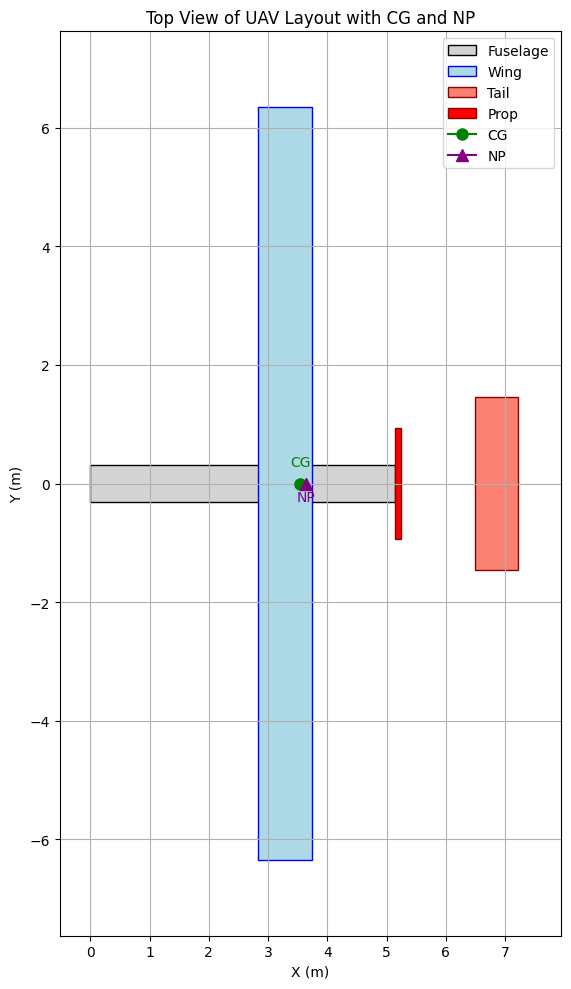

In [229]:


components, components_z = estimate_component_positions(predrop, hard_constraints, assumed_and_set, weights_dict_kg_no_fuel)

# components = {"avionics":components["avionics"], "Payload":components["internal_payload"]}

components = {}

h_tail_le_position = predrop["cruiseout_cg_from_nose_m"] + predrop["tail_arm_m"] - 0.25 * predrop["h_tail_chord_m"]

plot_uav_top_view(
    fuselage_length=predrop["fuselage_body_length_m"],
    fuselage_width=predrop["fuselage_body_width_m"],
    wing_span=predrop["wing_span_m"],
    wing_chord=predrop["chord_m"],
    wing_le_position=predrop["wing_le_position_m"],
    tail_span=predrop["h_tail_span_m"],
    tail_chord=predrop["h_tail_chord_m"],
    tail_le_position=h_tail_le_position,
    components=components,
    cg_position=predrop["cruiseback_cg_from_nose_m"],
    np_position=predrop["neutral_point_m"],
)



In [ ]:
at.